# PTSD Prediction Model: Multimodal LSTM with Cross-Attention

This notebook implements a deep learning model to predict PTSD from multimodal features (audio and visual). The model architecture includes:

1. Two-branch LSTM network (audio + visual)
2. Cross-modal attention mechanism
3. Class weighting to handle imbalanced data
4. Support for multiple feature types

To address the concern about using only egemaps and openface features, this implementation supports incorporating additional features like ResNet, VGG, and DenseNet.


In [1]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import gc

# Deep learning libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, LSTM, Dropout, Input, Concatenate, Attention, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam

# Scikit-learn for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
from sklearn.utils import class_weight

# Suppress warnings
import warnings
warnings.filterwarnings('ignore')

2025-05-03 15:08:01.448474: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-03 15:08:01.458088: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746284881.469084   78808 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746284881.472339   78808 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1746284881.480743   78808 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [2]:
# Set paths
DATA_PATH = "../../storage/sandeep/processed_data"
MODEL_PATH = "../../storage/sandeep/models"
RESULTS_PATH = "../../storage/sandeep/results"

# Create output directories
os.makedirs(MODEL_PATH, exist_ok=True)
os.makedirs(RESULTS_PATH, exist_ok=True)

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

## Loading Preprocessed Data

In our preprocessing notebook, we saved the data in a memory-efficient format:

- `{split}_audio.npy`: Audio sequences (egemaps features)
- `{split}_visual.npy`: Visual sequences (openface features)
- `{split}_labels.pkl`: PTSD labels and participant IDs

We'll now load this data and prepare it for model training.


In [3]:
# Function to load the preprocessed data
def load_processed_data(data_path, split):
    """Load the processed data for a specific split"""
    print(f"Loading {split} data...")
    
    # Load audio and visual data using memory-mapping
    audio_path = f"{data_path}/{split}_audio.npy"
    visual_path = f"{data_path}/{split}_visual.npy"
    
    # For large arrays, use memory mapping
    audio_data = np.load(audio_path, mmap_mode='r')
    visual_data = np.load(visual_path, mmap_mode='r')
    
    # Get actual data arrays
    audio_sequences = np.array(audio_data)
    visual_sequences = np.array(visual_data)
    
    # Load labels and participant IDs
    with open(f"{data_path}/{split}_labels.pkl", 'rb') as f:
        label_data = pickle.load(f)
    
    labels = np.array(label_data['labels'])
    participant_ids = label_data['participant_ids']
    
    print(f"  Audio sequences: {audio_sequences.shape}")
    print(f"  Visual sequences: {visual_sequences.shape}")
    print(f"  Labels: {labels.shape}")
    print(f"  PTSD positive: {sum(labels)}/{len(labels)} ({sum(labels)/len(labels)*100:.2f}%)")
    print(f"  Unique participants: {len(set(participant_ids))}")
    
    return audio_sequences, visual_sequences, labels, participant_ids

In [4]:
# Load the preprocessed data for all splits
train_audio, train_visual, train_labels, train_participants = load_processed_data(DATA_PATH, 'train')
dev_audio, dev_visual, dev_labels, dev_participants = load_processed_data(DATA_PATH, 'dev')
test_audio, test_visual, test_labels, test_participants = load_processed_data(DATA_PATH, 'test')

Loading train data...
  Audio sequences: (30820, 20, 24)
  Visual sequences: (30820, 20, 53)
  Labels: (476565,)
  PTSD positive: 151316/476565 (31.75%)
  Unique participants: 163
Loading dev data...
  Audio sequences: (17442, 20, 24)
  Visual sequences: (17442, 20, 53)
  Labels: (163406,)
  PTSD positive: 52085/163406 (31.87%)
  Unique participants: 56
Loading test data...
  Audio sequences: (19772, 20, 24)
  Visual sequences: (19772, 20, 53)
  Labels: (162953,)
  PTSD positive: 63501/162953 (38.97%)
  Unique participants: 56


## Enhanced Feature Extraction (Optional)

If you're concerned about using only egemaps and openface features, we can add more feature types. This section can be used to load additional feature data like ResNet, VGG, or DenseNet if available.


In [5]:
# Function to load additional feature types if available
def load_additional_features(data_path, feature_name):
    """Load additional feature types if they exist"""
    feature_files = {
        'train': f"{data_path}/train_{feature_name}.npy",
        'dev': f"{data_path}/dev_{feature_name}.npy",
        'test': f"{data_path}/test_{feature_name}.npy"
    }
    
    feature_data = {}
    for split, file_path in feature_files.items():
        if os.path.exists(file_path):
            feature_data[split] = np.load(file_path)
            print(f"Loaded {split} {feature_name} data: {feature_data[split].shape}")
        else:
            print(f"No {feature_name} data found for {split} split")
    
    return feature_data

In [7]:
# To load extra features, uncomment these lines. We can experiment with adding these later.
resnet_features = load_additional_features(DATA_PATH, 'resnet')
vgg_features = load_additional_features(DATA_PATH, 'vgg')
densenet_features = load_additional_features(DATA_PATH, 'densenet')

No resnet data found for train split
No resnet data found for dev split
No resnet data found for test split
No vgg data found for train split
No vgg data found for dev split
No vgg data found for test split
No densenet data found for train split
No densenet data found for dev split
No densenet data found for test split


## Cross-Modal Attention Mechanism

This mechanism allows the model to attend to relevant parts of one modality based on the context provided by another modality. It's a key component for multimodal fusion.


In [5]:
def cross_modal_attention(audio_features, visual_features, name_prefix=''):
    """Implement cross-modal attention between audio and visual features"""
    # Audio guided by visual context
    audio_with_visual_context = layers.Attention(
        name=f'{name_prefix}audio_visual_attention'
    )([audio_features, visual_features])
    
    # Visual guided by audio context
    visual_with_audio_context = layers.Attention(
        name=f'{name_prefix}visual_audio_attention'
    )([visual_features, audio_features])
    
    # Combine context-enhanced features
    enhanced_audio = layers.Concatenate(
        name=f'{name_prefix}enhanced_audio'
    )([audio_features, audio_with_visual_context])
    
    enhanced_visual = layers.Concatenate(
        name=f'{name_prefix}enhanced_visual'
    )([visual_features, visual_with_audio_context])
    
    return enhanced_audio, enhanced_visual

In [6]:
# Feature Engineering Functions
def extract_statistical_features(sequences):
    """Extract statistical features from sequences
    
    For each sequence (participant), we calculate statistical measures across the time 
    dimension to create a fixed-length feature vector regardless of sequence length.
    These features capture the distribution characteristics of each signal.
    """
    # Get dimensions
    n_samples, seq_len, n_features = sequences.shape
    
    # Initialize array to hold features
    # We'll extract 6 statistics for each feature dimension
    stat_features = np.zeros((n_samples, n_features * 6))
    
    print(f"Extracting statistical features from {n_samples} sequences with {n_features} features...")
    
    for i in range(n_samples):
        for j in range(n_features):
            # Extract feature sequence
            feat_seq = sequences[i, :, j]
            
            # Calculate core statistics
            mean_val = np.mean(feat_seq)
            std_val = np.std(feat_seq)
            min_val = np.min(feat_seq)
            max_val = np.max(feat_seq)
            range_val = max_val - min_val
            # Use quantiles for robustness to outliers
            q75_q25_val = np.percentile(feat_seq, 75) - np.percentile(feat_seq, 25)
            
            # Store in the feature array
            idx = j * 6
            stat_features[i, idx:idx+6] = [mean_val, std_val, min_val, max_val, range_val, q75_q25_val]
        
        # Show progress
        if i % 1000 == 0 and i > 0:
            print(f"Processed {i}/{n_samples} sequences")
    
    # Create feature names for interpretability
    feature_names = []
    for j in range(n_features):
        for stat in ['mean', 'std', 'min', 'max', 'range', 'iqr']:
            feature_names.append(f"feat{j+1}_{stat}")
    
    return stat_features, feature_names

In [7]:
def extract_temporal_features(sequences):
    """Extract temporal dynamics features that may indicate PTSD
    
    These features capture how signals change over time, variance in responses,
    and other temporal patterns that might be relevant to PTSD detection.
    """
    # Get dimensions
    n_samples, seq_len, n_features = sequences.shape
    
    # We'll extract 5 temporal features per input feature
    temp_features = np.zeros((n_samples, n_features * 5))
    
    print(f"Extracting temporal features from {n_samples} sequences...")
    
    for i in range(n_samples):
        for j in range(n_features):
            # Extract feature sequence
            feat_seq = sequences[i, :, j]
            
            # Calculate temporal features
            
            # 1. Rate of change (first derivative statistics)
            diffs = np.diff(feat_seq)
            mean_change = np.mean(np.abs(diffs))
            max_change = np.max(np.abs(diffs))
            
            # 2. Trend features
            # Simple linear regression slope
            x = np.arange(seq_len)
            slope, _, _, _, _ = np.polyfit(x, feat_seq, 1, full=True)
            slope = slope[0] if isinstance(slope, np.ndarray) else slope
            
            # 3. Variability features
            # Coefficient of variation (adjusts for magnitude)
            cv = np.std(feat_seq) / (np.mean(np.abs(feat_seq)) + 1e-10)
            
            # 4. Number of peaks/fluctuations (simplified)
            peaks = np.sum(np.logical_and(diffs[:-1] > 0, diffs[1:] < 0))
            
            # Store features
            idx = j * 5
            temp_features[i, idx:idx+5] = [mean_change, max_change, slope, cv, peaks]
        
        # Show progress
        if i % 1000 == 0 and i > 0:
            print(f"Processed {i}/{n_samples} sequences")
    
    # Create feature names for interpretability
    feature_names = []
    for j in range(n_features):
        for stat in ['mean_change', 'max_change', 'trend_slope', 'coef_var', 'peaks']:
            feature_names.append(f"feat{j+1}_{stat}")
    
    return temp_features, feature_names

In [8]:
def combine_engineered_features(audio_sequences, visual_sequences):
    """Combine statistical and temporal features from both modalities"""
    # Extract features from each modality
    audio_stat_features, audio_stat_names = extract_statistical_features(audio_sequences)
    audio_temp_features, audio_temp_names = extract_temporal_features(audio_sequences)
    
    visual_stat_features, visual_stat_names = extract_statistical_features(visual_sequences)
    visual_temp_features, visual_temp_names = extract_temporal_features(visual_sequences)
    
    # Combine all features
    all_features = np.hstack([
        audio_stat_features, audio_temp_features,
        visual_stat_features, visual_temp_features
    ])
    
    # Create prefixed feature names
    audio_stat_names = [f"audio_{name}" for name in audio_stat_names]
    audio_temp_names = [f"audio_{name}" for name in audio_temp_names]
    visual_stat_names = [f"visual_{name}" for name in visual_stat_names]
    visual_temp_names = [f"visual_{name}" for name in visual_temp_names]
    
    all_feature_names = audio_stat_names + audio_temp_names + visual_stat_names + visual_temp_names
    
    print(f"Combined feature shape: {all_features.shape}")
    print(f"Total features: {len(all_feature_names)}")
    
    return all_features, all_feature_names

## PTSD Prediction Model

Now we'll build the two-branch LSTM architecture with cross-modal attention.


In [9]:
def create_two_branch_model(audio_shape, visual_shape, lstm_units=64, dropout_rate=0.5):
    """Create a two-branch LSTM model with cross-modal attention"""
    # Input layers
    audio_input = Input(shape=audio_shape[1:], name='audio_input')
    visual_input = Input(shape=visual_shape[1:], name='visual_input')
    
    # Initial processing for audio with regularization
    audio_lstm1 = LSTM(lstm_units, return_sequences=True, 
                      kernel_regularizer=tf.keras.regularizers.l2(0.001),
                      name='audio_lstm1')(audio_input)
    audio_batch_norm = BatchNormalization(name='audio_batch_norm')(audio_lstm1)
    audio_dropout = Dropout(dropout_rate, name='audio_dropout')(audio_batch_norm)
    
    # Initial processing for visual with regularization
    visual_lstm1 = LSTM(lstm_units, return_sequences=True, 
                       kernel_regularizer=tf.keras.regularizers.l2(0.001),
                       name='visual_lstm1')(visual_input)
    visual_batch_norm = BatchNormalization(name='visual_batch_norm')(visual_lstm1)
    visual_dropout = Dropout(dropout_rate, name='visual_dropout')(visual_batch_norm)
    
    # Apply cross-modal attention
    enhanced_audio, enhanced_visual = cross_modal_attention(audio_dropout, visual_dropout, 'mid_')
    
    # Second-level processing with regularization
    audio_lstm2 = LSTM(lstm_units, return_sequences=False, 
                      kernel_regularizer=tf.keras.regularizers.l2(0.001),
                      name='audio_lstm2')(enhanced_audio)
    visual_lstm2 = LSTM(lstm_units, return_sequences=False, 
                       kernel_regularizer=tf.keras.regularizers.l2(0.001),
                       name='visual_lstm2')(enhanced_visual)
    
    # Fusion of modalities
    fusion = Concatenate(name='fusion')([audio_lstm2, visual_lstm2])
    fusion_dropout = Dropout(dropout_rate, name='fusion_dropout')(fusion)
    
    # Final classification layers (reduced complexity)
    dense1 = Dense(32, activation='relu', 
                  kernel_regularizer=tf.keras.regularizers.l2(0.001),
                  name='dense1')(fusion_dropout)
    output = Dense(1, activation='sigmoid', name='output')(dense1)
    
    # Create and compile model
    model = Model(inputs=[audio_input, visual_input], outputs=output, name='PTSD_predictor')
    
    return model

In [10]:
# Create the model
model = create_two_branch_model(train_audio.shape, train_visual.shape)

# Visualize the model architecture
model.summary()

I0000 00:00:1746283061.554766   46331 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9957 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 SUPER, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "PTSD_predictor"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ audio_input         │ (None, 20, 24)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ visual_input        │ (None, 20, 53)    │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_lstm1 (LSTM)  │ (None, 20, 64)    │     22,784 │ audio_input[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ visual_lstm1 (LSTM) │ (None, 20, 64)    │     30,208 │ visual_input[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_batch_norm    │ (None, 20, 64)    │        256 │ audio_lstm1[0][0] │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ visual_batch_norm   │ (None, 20, 64)    │        256 │ visual_lstm1[0][… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_dropout       │ (None, 20, 64)    │          0 │ audio_batch_norm… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ visual_dropout      │ (None, 20, 64)    │          0 │ visual_batch_nor… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid_audio_visual_a… │ (None, 20, 64)    │          0 │ audio_dropout[0]… │
│ (Attention)         │                   │            │ visual_dropout[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid_visual_audio_a… │ (None, 20, 64)    │          0 │ visual_dropout[0… │
│ (Attention)         │                   │            │ audio_dropout[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid_enhanced_audio  │ (None, 20, 128)   │          0 │ audio_dropout[0]… │
│ (Concatenate)       │                   │            │ mid_audio_visual… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mid_enhanced_visual │ (None, 20, 128)   │          0 │ visual_dropout[0… │
│ (Concatenate)       │                   │            │ mid_visual_audio… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ audio_lstm2 (LSTM)  │ (None, 64)        │     49,408 │ mid_enhanced_aud… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ visual_lstm2 (LSTM) │ (None, 64)        │     49,408 │ mid_enhanced_vis… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion              │ (None, 128)       │          0 │ audio_lstm2[0][0… │
│ (Concatenate)       │                   │            │ visual_lstm2[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ fusion_dropout      │ (None, 128)       │          0 │ fusion[0][0]      │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense1 (Dense)      │ (None, 32)        │      4,128 │ fusion_dropout[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ output (Dense)      │ (None, 1)         │         33 │ dense1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 156,481 (611.25 KB)

 Trainable params: 156,225 (610.25 KB)

 Non-trainable params: 256 (1.00 KB)

## Training Setup with Class Weighting

To address class imbalance, we'll use class weights during training.


In [11]:
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss function for binary classification with imbalanced data
    
    Arguments:
        gamma: focusing parameter that controls how much to focus on hard examples
        alpha: weighting factor for the positive class
    
    Returns:
        Focal loss function
    """
    def focal_loss_fn(y_true, y_pred):
        import tensorflow.keras.backend as K
        
        # Clip predictions to prevent numerical instability
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Calculate focal loss
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        
        # Apply focal term
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) - \
               K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    
    return focal_loss_fn

In [12]:
# Calculate class weights to handle imbalance
class_weights = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weight_dict = {i: w for i, w in enumerate(class_weights)}
print(f"Class weights: {class_weight_dict}")

# Compile the model with focal loss for better handling of class imbalance
model.compile(
    optimizer=Adam(learning_rate=0.0005),  # Lower learning rate
    loss=focal_loss(gamma=2.0, alpha=0.25), # Using focal loss instead of binary_crossentropy
    metrics=['accuracy',
             tf.keras.metrics.Precision(name='precision'), 
             tf.keras.metrics.Recall(name='recall'),
             tf.keras.metrics.AUC(name='auc')]
)

Class weights: {0: np.float64(0.7326156267967003), 1: np.float64(1.5747343308044093)}


In [13]:
# Define improved callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',  # Change from val_auc to val_loss
        patience=5,          # Reduce patience to stop earlier
        mode='min',          # Change to 'min' since we're monitoring loss
        restore_best_weights=True,
        verbose=1
    ),
    ModelCheckpoint(
        filepath=f"{MODEL_PATH}/best_model.h5",
        monitor='val_loss',  # Change to val_loss
        mode='min',         # Change to 'min'
        save_best_only=True
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,        # More aggressive reduction
        patience=3,        # Reduce patience
        min_lr=0.000001,
        verbose=1
    )
]

## Training the Model

Now we'll train the model with our multimodal data.


In [14]:
def augment_sequence(sequence, noise_level=0.05):
    """Add random noise to time series data for augmentation"""
    noise = noise_level * np.random.normal(0, 1, sequence.shape)
    return sequence + noise

In [15]:
def process_with_gpu_memory_constraints(train_audio, train_visual, train_labels, dev_audio, dev_visual, dev_labels, batch_size=32):
    """
    Process data in smaller batches to avoid GPU memory issues and apply data augmentation
    to address class imbalance
    """
    print("Processing data with GPU memory constraints and data augmentation...")
    
    # 1. Use CPU for initial tensor conversions
    with tf.device('/CPU:0'):
        # Make sure labels match the size of features
        num_train_samples = min(len(train_audio), len(train_visual))
        train_labels_subset = train_labels[:num_train_samples]
        
        num_dev_samples = min(len(dev_audio), len(dev_visual))
        dev_labels_subset = dev_labels[:num_dev_samples]
        
        # Apply data augmentation for minority class (PTSD positive)
        print("Applying data augmentation to balance classes...")
        augmented_audio = []
        augmented_visual = []
        augmented_labels = []
        
        # Count positive samples
        positive_count = np.sum(train_labels_subset == 1)
        negative_count = np.sum(train_labels_subset == 0)
        augmentation_factor = min(3, int(negative_count / positive_count) - 1)
        print(f"Class distribution before augmentation: {positive_count} positive, {negative_count} negative")
        print(f"Augmentation factor: {augmentation_factor}x")
        
        for i in range(num_train_samples):
            if train_labels_subset[i] == 1:  # PTSD positive class
                # Add multiple augmented samples for each positive sample
                for _ in range(augmentation_factor):
                    augmented_audio.append(augment_sequence(train_audio[i]))
                    augmented_visual.append(augment_sequence(train_visual[i]))
                    augmented_labels.append(1)
        
        # Append augmented samples to original data
        train_audio_combined = np.vstack([train_audio[:num_train_samples], np.array(augmented_audio)])
        train_visual_combined = np.vstack([train_visual[:num_train_samples], np.array(augmented_visual)])
        train_labels_combined = np.append(train_labels_subset, augmented_labels)
        
        print(f"Added {len(augmented_labels)} augmented positive samples")
        print(f"Class distribution after augmentation: {np.sum(train_labels_combined == 1)}/{len(train_labels_combined)} positive samples")
        
        # Create sample weights for class imbalance
        classes = np.unique(train_labels_combined)
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=train_labels_combined
        )
        class_weight_dict = {i: w for i, w in enumerate(class_weights)}
        
        # Create dataset objects to handle memory efficiently
        train_dataset = tf.data.Dataset.from_tensor_slices(
            ((train_audio_combined, train_visual_combined), train_labels_combined)
        ).shuffle(buffer_size=10000).batch(batch_size)
        
        val_dataset = tf.data.Dataset.from_tensor_slices(
            ((dev_audio[:num_dev_samples], dev_visual[:num_dev_samples]), dev_labels_subset)
        ).batch(batch_size)
    
    # 2. Return the TensorFlow datasets and related info
    return {
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'class_weight_dict': class_weight_dict,
        'train_samples': len(train_labels_combined),
        'val_samples': num_dev_samples,
        'batch_size': batch_size
    }

In [16]:
# Process the data using our memory-efficient approach with data augmentation
batch_size = 32
print(f"\nUsing batch size of {batch_size} for memory efficiency")

# Create the TensorFlow datasets - this processes the data efficiently and applies data augmentation
processed_data = process_with_gpu_memory_constraints(
    train_audio, 
    train_visual, 
    train_labels,
    dev_audio,
    dev_visual,
    dev_labels,
    batch_size=batch_size
)

# Extract the datasets and class weights
train_dataset = processed_data['train_dataset']
val_dataset = processed_data['val_dataset']
class_weight_dict = processed_data['class_weight_dict']

# Print information about our data
print(f"\nNumber of training samples after augmentation: {processed_data['train_samples']}")
print(f"Number of validation samples: {processed_data['val_samples']}")
print(f"Using class weights: {class_weight_dict}")

# Train using the TensorFlow Dataset API (memory-efficient)
print("\nStarting training with TensorFlow Dataset API (memory-efficient)...")

history = model.fit(
    train_dataset,
    epochs=30,  # Reduce epochs to prevent overfitting
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)


Using batch size of 32 for memory efficiency
Processing data with GPU memory constraints and data augmentation...
Applying data augmentation to balance classes...
Class distribution before augmentation: 7120 positive, 23700 negative
Augmentation factor: 2x
Added 14240 augmented positive samples
Class distribution after augmentation: 21360/45060 positive samples

Number of training samples after augmentation: 45060
Number of validation samples: 17442
Using class weights: {0: np.float64(0.950632911392405), 1: np.float64(1.0547752808988764)}

Starting training with TensorFlow Dataset API (memory-efficient)...
Epoch 1/30


I0000 00:00:1746283082.833519   49741 cuda_dnn.cc:529] Loaded cuDNN version 90300


1409/1409 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8788 - auc: 0.7445 - loss: 0.2502 - precision: 0.6757 - recall: 0.3479

1409/1409 ━━━━━━━━━━━━━━━━━━━━ 13s 7ms/step - accuracy: 0.8788 - auc: 0.7446 - loss: 0.2501 - precision: 0.6759 - recall: 0.3482 - val_accuracy: 0.4416 - val_auc: 0.4243 - val_loss: 0.2021 - val_precision: 0.5248 - val_recall: 0.2766 - learning_rate: 5.0000e-04
Epoch 2/30
1408/1409 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9450 - auc: 0.8282 - loss: 0.0400 - precision: 0.7505 - recall: 0.6711

1409/1409 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9450 - auc: 0.8284 - loss: 0.0399 - precision: 0.7509 - recall: 0.6715 - val_accuracy: 0.4649 - val_auc: 0.4433 - val_loss: 0.1940 - val_precision: 0.5694 - val_recall: 0.2735 - learning_rate: 5.0000e-04
Epoch 3/30
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9629 - auc: 0.8423 - loss: 0.0266 - precision: 0.7755 - recall: 0.7214 - val_accuracy: 0.4413 - val_auc: 0.4366 - val_loss: 0.2256 - val_precision: 0.5340 - val_recall: 0.2013 - learning_rate: 5.0000e-04
Epoch 4/30
1409/1409 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - accuracy: 0.9684 - auc: 0.8460 - loss: 0.0212 - precision: 0.7818 - recall: 0.7280 - val_accuracy: 0.4479 - val_auc: 0.4422 - val_loss: 0.2702 - val_precision: 0.5493 - val_recall: 0.2067 - learning_rate: 5.0000e-04
Epoch 5/30
1402/1409 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9735 - auc: 0.8473 - loss: 0.0203 - precision: 0.7956 - recall: 0.7561
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0

## Evaluate the Model

Let's evaluate the model's performance on the test set.


In [ ]:
# Plot training history
def plot_history(history):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Plot accuracy
    axes[0, 0].plot(history.history['accuracy'], label='Train')
    axes[0, 0].plot(history.history['val_accuracy'], label='Validation')
    axes[0, 0].set_title('Accuracy')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Accuracy')
    axes[0, 0].legend()
    
    # Plot loss
    axes[0, 1].plot(history.history['loss'], label='Train')
    axes[0, 1].plot(history.history['val_loss'], label='Validation')
    axes[0, 1].set_title('Loss')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Loss')
    axes[0, 1].legend()
    
    # Plot AUC
    axes[1, 0].plot(history.history['auc'], label='Train')
    axes[1, 0].plot(history.history['val_auc'], label='Validation')
    axes[1, 0].set_title('AUC')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].legend()
    
    # Plot recall and precision
    axes[1, 1].plot(history.history['precision'], label='Precision (Train)')
    axes[1, 1].plot(history.history['val_precision'], label='Precision (Val)')
    axes[1, 1].plot(history.history['recall'], label='Recall (Train)')
    axes[1, 1].plot(history.history['val_recall'], label='Recall (Val)')
    axes[1, 1].set_title('Precision & Recall')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].legend()
    
    plt.tight_layout()
    plt.savefig(f"{RESULTS_PATH}/training_history.png")
    plt.show()

# Plot training history
plot_history(history)

# Evaluation of test set

Evaluating on 19772 test samples
618/618 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Test Set Evaluation:
Accuracy: 0.6469
Precision: 0.1282
Recall: 0.2987
F1 Score: 0.1794
Confusion Matrix:
[[12028  5190]
 [ 1791   763]]


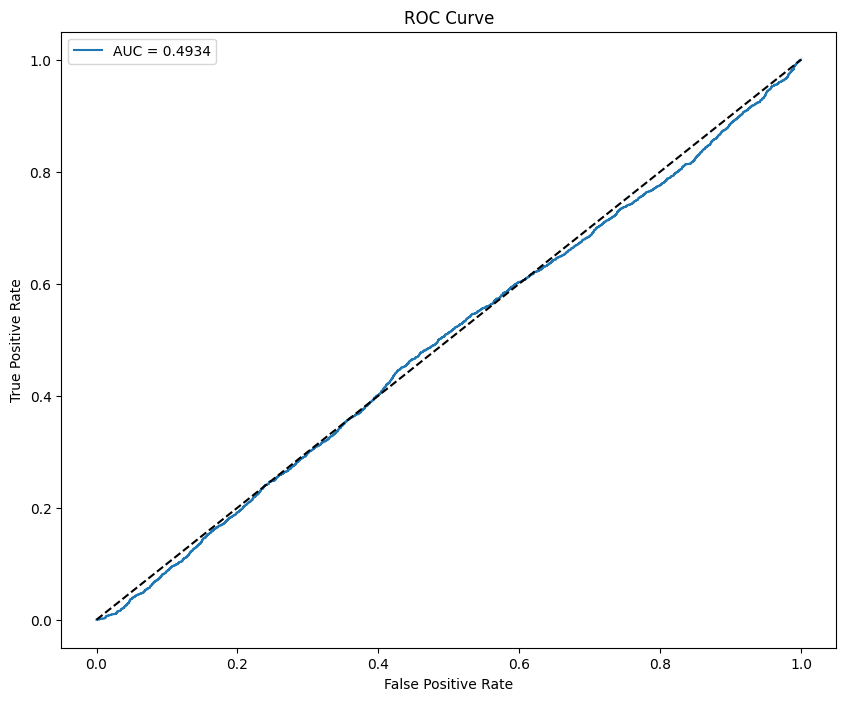

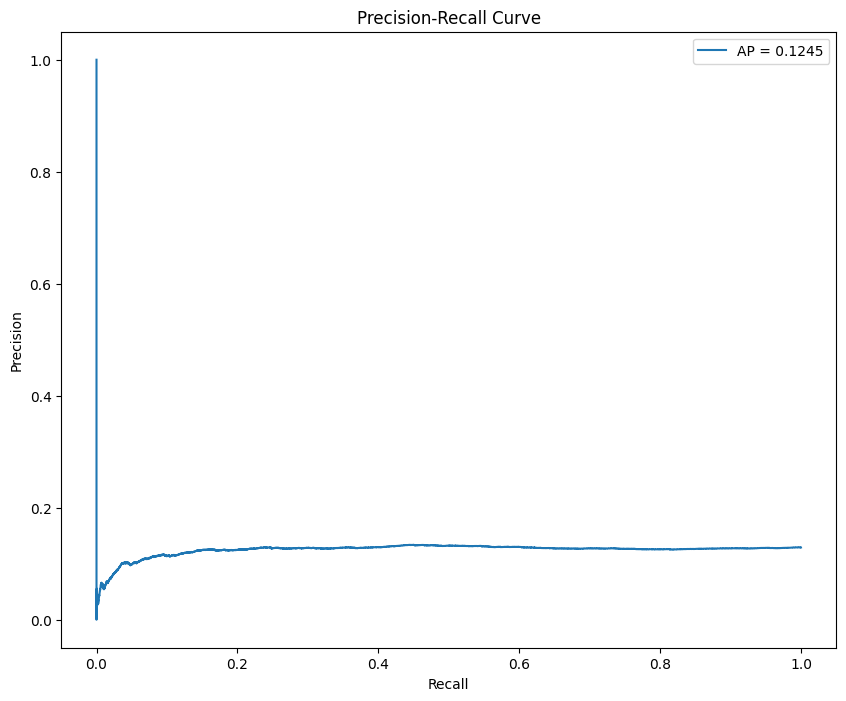

In [19]:
# Evaluate on test set
def evaluate_test_set(model, test_audio, test_visual, test_labels):
    # Make sure we're evaluating on the same number of samples as the labels
    num_test_samples = min(len(test_audio), len(test_visual), len(test_labels))
    print(f"Evaluating on {num_test_samples} test samples")
    
    # Get predictions
    test_pred_probs = model.predict([test_audio[:num_test_samples], test_visual[:num_test_samples]])
    test_preds = (test_pred_probs > 0.5).astype(int).flatten()
    
    # Make sure we're using the matching subset of labels
    test_labels_subset = test_labels[:num_test_samples]
    
    # Calculate metrics
    accuracy = accuracy_score(test_labels_subset, test_preds)
    precision = precision_score(test_labels_subset, test_preds)
    recall = recall_score(test_labels_subset, test_preds)
    f1 = f1_score(test_labels_subset, test_preds)
    cm = confusion_matrix(test_labels_subset, test_preds)
    
    # Print results
    print("\nTest Set Evaluation:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    print("Confusion Matrix:")
    print(cm)
    
    # Calculate and plot ROC curve
    fpr, tpr, _ = roc_curve(test_labels_subset, test_pred_probs)
    roc_auc = auc(fpr, tpr)
    
    plt.figure(figsize=(10, 8))
    plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend()
    plt.savefig(f"{RESULTS_PATH}/roc_curve.png")
    plt.show()
    
    # Calculate and plot precision-recall curve
    precision_curve, recall_curve, _ = precision_recall_curve(test_labels_subset, test_pred_probs)
    average_precision = average_precision_score(test_labels_subset, test_pred_probs)
    
    plt.figure(figsize=(10, 8))
    plt.plot(recall_curve, precision_curve, label=f'AP = {average_precision:.4f}')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve')
    plt.legend()
    plt.savefig(f"{RESULTS_PATH}/pr_curve.png")
    plt.show()
    
    # Return metrics for further analysis
    metrics = {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': roc_auc,
        'confusion_matrix': cm,
        'predictions': test_preds,
        'probabilities': test_pred_probs
    }
    
    return metrics

# Evaluate on test set
test_metrics = evaluate_test_set(model, test_audio, test_visual, test_labels)

## Experiment with Additional Features (Optional)

If needed, we can modify the model to incorporate additional features from deeper models like ResNet or VGG.


In [ ]:
# Function to create an enhanced model with additional features
def create_enhanced_model(audio_shape, visual_shape, deep_visual_shape=None, lstm_units=128, dropout_rate=0.3):
    """Create an enhanced model that can use additional deep features"""
    # Input layers
    audio_input = Input(shape=audio_shape[1:], name='audio_input')
    visual_input = Input(shape=visual_shape[1:], name='visual_input')
    
    # Add deep visual input if provided
    inputs = [audio_input, visual_input]
    if deep_visual_shape is not None:
        deep_visual_input = Input(shape=deep_visual_shape[1:], name='deep_visual_input')
        inputs.append(deep_visual_input)
    
    # Branch 1: Audio processing
    audio_lstm1 = LSTM(lstm_units, return_sequences=True, name='audio_lstm1')(audio_input)
    audio_bn = BatchNormalization()(audio_lstm1)
    audio_dropout = Dropout(dropout_rate)(audio_bn)
    
    # Branch 2: Visual processing
    visual_lstm1 = LSTM(lstm_units, return_sequences=True, name='visual_lstm1')(visual_input)
    visual_bn = BatchNormalization()(visual_lstm1)
    visual_dropout = Dropout(dropout_rate)(visual_bn)
    
    # Branch 3: Deep visual features (if provided)
    if deep_visual_shape is not None:
        deep_visual_lstm = LSTM(lstm_units, return_sequences=True, name='deep_visual_lstm1')(deep_visual_input)
        deep_visual_bn = BatchNormalization()(deep_visual_lstm)
        deep_visual_dropout = Dropout(dropout_rate)(deep_visual_bn)
        
        # Cross-modal attention between all branches
        enhanced_audio, enhanced_visual = cross_modal_attention(audio_dropout, visual_dropout, 'basic_')
        enhanced_deep, _ = cross_modal_attention(deep_visual_dropout, audio_dropout, 'deep_')
        
        # Second level LSTMs
        audio_lstm2 = LSTM(lstm_units, return_sequences=False)(enhanced_audio)
        visual_lstm2 = LSTM(lstm_units, return_sequences=False)(enhanced_visual)
        deep_lstm2 = LSTM(lstm_units, return_sequences=False)(enhanced_deep)
        
        # Combine all branches
        fusion = Concatenate()([audio_lstm2, visual_lstm2, deep_lstm2])
    else:
        # Standard two-branch model
        enhanced_audio, enhanced_visual = cross_modal_attention(audio_dropout, visual_dropout)
        
        audio_lstm2 = LSTM(lstm_units, return_sequences=False)(enhanced_audio)
        visual_lstm2 = LSTM(lstm_units, return_sequences=False)(enhanced_visual)
        
        fusion = Concatenate()([audio_lstm2, visual_lstm2])
    
    # Final layers
    fusion_dropout = Dropout(dropout_rate)(fusion)
    dense = Dense(64, activation='relu')(fusion_dropout)
    output = Dense(1, activation='sigmoid')(dense)
    
    # Create model
    model = Model(inputs=inputs, outputs=output)
    
    return model

# For future experiments with additional features, uncomment these lines:
'''
# Example of creating an enhanced model with ResNet features
if 'train' in resnet_features and 'dev' in resnet_features and 'test' in resnet_features:
    enhanced_model = create_enhanced_model(
        train_audio.shape, 
        train_visual.shape,
        resnet_features['train'].shape
    )
    enhanced_model.summary()
'''

In [ ]:
# Save the trained model
model.save(f"{MODEL_PATH}/final_model.h5")
print(f"Model saved to {MODEL_PATH}/final_model.h5")

# Save test metrics
with open(f"{RESULTS_PATH}/test_metrics.pkl", 'wb') as f:
    pickle.dump(test_metrics, f)

# Save training history
with open(f"{RESULTS_PATH}/training_history.pkl", 'wb') as f:
    pickle.dump(history.history, f)

print("Results saved successfully!")

## Conclusions and Next Steps

This notebook has implemented a two-branch LSTM model with cross-modal attention for PTSD prediction from multimodal data. The key components include:

1. **Multimodal Data Integration**: Combining audio (egemaps) and visual (openface) features
2. **Cross-Modal Attention**: Enabling each modality to focus on relevant parts of the other
3. **Class Weighting**: Addressing the class imbalance issue
4. **Comprehensive Evaluation**: Using metrics suited for imbalanced classification problems

### Addressing Feature Concern

While we've primarily used egemaps and openface features as they were consistently available across all participants, the architecture can be extended to incorporate additional features like ResNet, VGG, and DenseNet if desired. The `create_enhanced_model` function provides a framework for this integration.

### Future Improvements

1. **Feature Engineering**: Create temporal dynamic features (rates of change, variability)
2. **Architecture Optimization**: Experiment with different LSTM configurations and attention mechanisms
3. **Ensemble Methods**: Combine multiple models trained on different feature sets
4. **Hyperparameter Tuning**: Optimize learning rate, batch size, and other hyperparameters


In [ ]:
def augment_sequence(sequence, noise_level=0.05):
    """Add random noise to time series data for augmentation"""
    noise = noise_level * np.random.normal(0, 1, sequence.shape)
    return sequence + noise

In [ ]:
def process_with_gpu_memory_constraints(train_audio, train_visual, train_labels, dev_audio, dev_visual, dev_labels, batch_size=32):
    """
    Process data in smaller batches to avoid GPU memory issues and apply data augmentation
    to address class imbalance
    """
    print("Processing data with GPU memory constraints and data augmentation...")
    
    # 1. Use CPU for initial tensor conversions
    with tf.device('/CPU:0'):
        # Make sure labels match the size of features
        num_train_samples = min(len(train_audio), len(train_visual))
        train_labels_subset = train_labels[:num_train_samples]
        
        num_dev_samples = min(len(dev_audio), len(dev_visual))
        dev_labels_subset = dev_labels[:num_dev_samples]
        
        # Apply data augmentation for minority class (PTSD positive)
        print("Applying data augmentation to balance classes...")
        augmented_audio = []
        augmented_visual = []
        augmented_labels = []
        
        # Count positive samples
        positive_count = np.sum(train_labels_subset == 1)
        negative_count = np.sum(train_labels_subset == 0)
        augmentation_factor = min(3, int(negative_count / positive_count) - 1)
        print(f"Class distribution before augmentation: {positive_count} positive, {negative_count} negative")
        print(f"Augmentation factor: {augmentation_factor}x")
        
        for i in range(num_train_samples):
            if train_labels_subset[i] == 1:  # PTSD positive class
                # Add multiple augmented samples for each positive sample
                for _ in range(augmentation_factor):
                    augmented_audio.append(augment_sequence(train_audio[i]))
                    augmented_visual.append(augment_sequence(train_visual[i]))
                    augmented_labels.append(1)
        
        # Append augmented samples to original data
        train_audio_combined = np.vstack([train_audio[:num_train_samples], np.array(augmented_audio)])
        train_visual_combined = np.vstack([train_visual[:num_train_samples], np.array(augmented_visual)])
        train_labels_combined = np.append(train_labels_subset, augmented_labels)
        
        print(f"Added {len(augmented_labels)} augmented positive samples")
        print(f"Class distribution after augmentation: {np.sum(train_labels_combined == 1)}/{len(train_labels_combined)} positive samples")
        
        # Create sample weights for class imbalance
        classes = np.unique(train_labels_combined)
        class_weights = class_weight.compute_class_weight(
            class_weight='balanced',
            classes=classes,
            y=train_labels_combined
        )
        class_weight_dict = {i: w for i, w in enumerate(class_weights)}
        
        # Create dataset objects to handle memory efficiently
        train_dataset = tf.data.Dataset.from_tensor_slices(
            ((train_audio_combined, train_visual_combined), train_labels_combined)
        ).shuffle(buffer_size=10000).batch(batch_size)
        
        val_dataset = tf.data.Dataset.from_tensor_slices(
            ((dev_audio[:num_dev_samples], dev_visual[:num_dev_samples]), dev_labels_subset)
        ).batch(batch_size)
    
    # 2. Return the TensorFlow datasets and related info
    return {
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'class_weight_dict': class_weight_dict,
        'train_samples': len(train_labels_combined),
        'val_samples': num_dev_samples,
        'batch_size': batch_size
    }

In [ ]:
def focal_loss(gamma=2.0, alpha=0.25):
    """
    Focal Loss function for binary classification with imbalanced data
    
    Arguments:
        gamma: focusing parameter that controls how much to focus on hard examples
        alpha: weighting factor for the positive class
    
    Returns:
        Focal loss function
    """
    def focal_loss_fn(y_true, y_pred):
        import tensorflow.keras.backend as K
        
        # Clip predictions to prevent numerical instability
        y_pred = K.clip(y_pred, K.epsilon(), 1 - K.epsilon())
        
        # Calculate focal loss
        pt_1 = tf.where(tf.equal(y_true, 1), y_pred, tf.ones_like(y_pred))
        pt_0 = tf.where(tf.equal(y_true, 0), y_pred, tf.zeros_like(y_pred))
        
        # Apply focal term
        return -K.mean(alpha * K.pow(1. - pt_1, gamma) * K.log(pt_1 + K.epsilon())) - \
               K.mean((1 - alpha) * K.pow(pt_0, gamma) * K.log(1. - pt_0 + K.epsilon()))
    
    return focal_loss_fn

In [ ]:
# Feature Engineering Functions
def extract_statistical_features(sequences):
    """Extract statistical features from sequences
    
    For each sequence (participant), we calculate statistical measures across the time 
    dimension to create a fixed-length feature vector regardless of sequence length.
    These features capture the distribution characteristics of each signal.
    """
    # Get dimensions
    n_samples, seq_len, n_features = sequences.shape
    
    # Initialize array to hold features
    # We'll extract 6 statistics for each feature dimension
    stat_features = np.zeros((n_samples, n_features * 6))
    
    print(f"Extracting statistical features from {n_samples} sequences with {n_features} features...")
    
    for i in range(n_samples):
        for j in range(n_features):
            # Extract feature sequence
            feat_seq = sequences[i, :, j]
            
            # Calculate core statistics
            mean_val = np.mean(feat_seq)
            std_val = np.std(feat_seq)
            min_val = np.min(feat_seq)
            max_val = np.max(feat_seq)
            range_val = max_val - min_val
            # Use quantiles for robustness to outliers
            q75_q25_val = np.percentile(feat_seq, 75) - np.percentile(feat_seq, 25)
            
            # Store in the feature array
            idx = j * 6
            stat_features[i, idx:idx+6] = [mean_val, std_val, min_val, max_val, range_val, q75_q25_val]
        
        # Show progress
        if i % 1000 == 0 and i > 0:
            print(f"Processed {i}/{n_samples} sequences")
    
    # Create feature names for interpretability
    feature_names = []
    for j in range(n_features):
        for stat in ['mean', 'std', 'min', 'max', 'range', 'iqr']:
            feature_names.append(f"feat{j+1}_{stat}")
    
    return stat_features, feature_names

def extract_temporal_features(sequences):
    """Extract temporal dynamics features that may indicate PTSD
    
    These features capture how signals change over time, variance in responses,
    and other temporal patterns that might be relevant to PTSD detection.
    """
    # Get dimensions
    n_samples, seq_len, n_features = sequences.shape
    
    # We'll extract 5 temporal features per input feature
    temp_features = np.zeros((n_samples, n_features * 5))
    
    print(f"Extracting temporal features from {n_samples} sequences...")
    
    for i in range(n_samples):
        for j in range(n_features):
            # Extract feature sequence
            feat_seq = sequences[i, :, j]
            
            # Calculate temporal features
            
            # 1. Rate of change (first derivative statistics)
            diffs = np.diff(feat_seq)
            mean_change = np.mean(np.abs(diffs))
            max_change = np.max(np.abs(diffs))
            
            # 2. Trend features
            # Simple linear regression slope
            x = np.arange(seq_len)
            slope, _, _, _, _ = np.polyfit(x, feat_seq, 1, full=True)
            slope = slope[0] if isinstance(slope, np.ndarray) else slope
            
            # 3. Variability features
            # Coefficient of variation (adjusts for magnitude)
            cv = np.std(feat_seq) / (np.mean(np.abs(feat_seq)) + 1e-10)
            
            # 4. Number of peaks/fluctuations (simplified)
            peaks = np.sum(np.logical_and(diffs[:-1] > 0, diffs[1:] < 0))
            
            # Store features
            idx = j * 5
            temp_features[i, idx:idx+5] = [mean_change, max_change, slope, cv, peaks]
        
        # Show progress
        if i % 1000 == 0 and i > 0:
            print(f"Processed {i}/{n_samples} sequences")
    
    # Create feature names for interpretability
    feature_names = []
    for j in range(n_features):
        for stat in ['mean_change', 'max_change', 'trend_slope', 'coef_var', 'peaks']:
            feature_names.append(f"feat{j+1}_{stat}")
    
    return temp_features, feature_names

def combine_engineered_features(audio_sequences, visual_sequences):
    """Combine statistical and temporal features from both modalities"""
    # Extract features from each modality
    audio_stat_features, audio_stat_names = extract_statistical_features(audio_sequences)
    audio_temp_features, audio_temp_names = extract_temporal_features(audio_sequences)
    
    visual_stat_features, visual_stat_names = extract_statistical_features(visual_sequences)
    visual_temp_features, visual_temp_names = extract_temporal_features(visual_sequences)
    
    # Combine all features
    all_features = np.hstack([
        audio_stat_features, audio_temp_features,
        visual_stat_features, visual_temp_features
    ])
    
    # Create prefixed feature names
    audio_stat_names = [f"audio_{name}" for name in audio_stat_names]
    audio_temp_names = [f"audio_{name}" for name in audio_temp_names]
    visual_stat_names = [f"visual_{name}" for name in visual_stat_names]
    visual_temp_names = [f"visual_{name}" for name in visual_temp_names]
    
    all_feature_names = audio_stat_names + audio_temp_names + visual_stat_names + visual_temp_names
    
    print(f"Combined feature shape: {all_features.shape}")
    print(f"Total features: {len(all_feature_names)}")
    
    return all_features, all_feature_names